# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Константинов Вячеслав Сергеевич`

Группа: `MADE-ML-31`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [2]:
!pip3 install geopandas

     |████████████████████████████████| 972kB 4.6MB/s 
     |████████████████████████████████| 14.8MB 241kB/s 
     |████████████████████████████████| 10.9MB 46.4MB/s 


In [3]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import random
import numpy as np

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
world = world.set_crs(epsg=4326)
world['centroid_column'] = world.centroid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


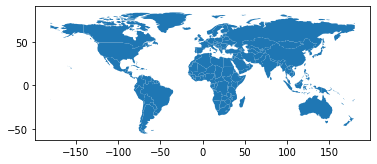

In [6]:
world.plot()

In [7]:
borders = world[world.name == "Afghanistan"]['geometry']
center = world[world.name == "Afghanistan"]['centroid_column']

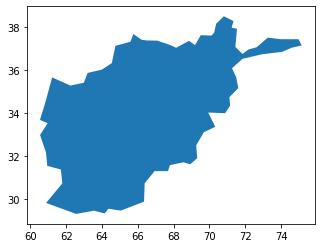

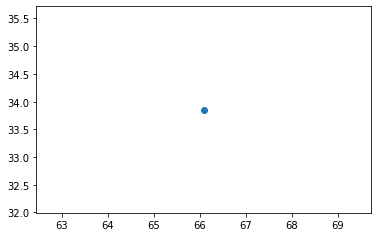

In [8]:
borders.plot()
center.plot()

In [9]:
def haversin_dist_points_km(point1, point2, R=6370, lat_log=True):
    if lat_log:
        lat1, log1 = point1.coords[0]
        lat2, log2 = point2.coords[0]
    else:
        log1, lat1 = point1.coords[0]
        log2, lat2 = point2.coords[0]
    
    h = np.sin(np.pi*0.5*(lat2 - lat1)/180) ** 2 + np.cos(np.pi*lat1/180) * np.cos(np.pi*lat2/180) * (np.sin(np.pi*0.5*(log2 - log1)/180)) ** 2
    return 2 * R * np.arcsin(np.sqrt(h))

def hav(f):
    return 0.5 * (1 - np.cos(f))

In [10]:
list(borders.contains(center.values[0]))[0]

True

In [11]:
def generate_point(borders, center_point, R=6370):
    path = []
    path_folium = []
    
    lat_min, lat_max = -89.5, 89.5
    log_min, log_max = -180, 180
    
    current_point = Point(random.uniform(log_min, log_max), random.uniform(lat_min, lat_max))
    current_dist = haversin_dist_points_km(center_point, current_point, R=R, lat_log=False)
    
    res_log = 1 - 2*hav(current_dist/R)/(np.cos(np.pi*current_point.coords[0][1]/180)**2)
    res_lat = 1 - 2*hav(current_dist/R)
    
    if abs(res_log) > 1:
        res_log = np.sign(res_log)
    if abs(res_lat) > 1:
        res_lat = np.sign(res_lat)
        
    delta_log = 180*abs(np.arccos(res_log))/np.pi
    delta_lat = 180*abs(np.arccos(res_lat))/np.pi
    
    path.append(current_point)
    path_folium.append([current_point.coords[0][1], current_point.coords[0][0]])
    
    lat_min = max(-89.5, current_point.coords[0][1] - delta_lat)
    lat_max = min(89.5, current_point.coords[0][1] + delta_lat)
    log_min = max(-89.5, current_point.coords[0][0] - delta_log)
    log_max = min(89.5, current_point.coords[0][0] + delta_log)
    
    while list(borders.contains(current_point))[0] == False:
        
        new_point = Point(random.uniform(log_min, log_max), random.uniform(lat_min, lat_max))
        new_dist = haversin_dist_points_km(center_point, new_point, R=R, lat_log=False)
        
        if list(borders.contains(new_point))[0]:
            path.append(new_point)
            path_folium.append([new_point.coords[0][1], new_point.coords[0][0]])
            return path, path_folium
        elif new_dist < current_dist:
            current_point = new_point
            current_dist = new_dist
            
            res_log = 1 - 2*hav(current_dist/R)/(np.cos(np.pi*current_point.coords[0][1]/180)**2)
            res_lat = 1 - 2*hav(current_dist/R)

            if abs(res_log) > 1:
                res_log = np.sign(res_log)
            if abs(res_lat) > 1:
                res_lat = np.sign(res_lat)
            delta_log = 180*abs(np.arccos(res_log))/np.pi
            delta_lat = 180*abs(np.arccos(res_lat))/np.pi 
            
            path.append(current_point)
            path_folium.append([current_point.coords[0][1], current_point.coords[0][0]])

            lat_min = max(-89.5, current_point.coords[0][1] - delta_lat)
            lat_max = min(89.5, current_point.coords[0][1] + delta_lat)
            log_min = max(-89.5, current_point.coords[0][0] - delta_log)
            log_max = min(89.5, current_point.coords[0][0] + delta_log)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [12]:
import folium

polygon_geom = borders.geometry.values[0]
m = folium.Map([center.values[0].coords[0][1], center.values[0].coords[0][0]], 
               zoom_start=2, tiles='cartodbpositron')

points = generate_point(borders, center.values[0])[1]

for idx, each_point in enumerate(points):
    folium.Marker(
        each_point,
        popup=str(idx),
    ).add_to(m)

folium.PolyLine(
    points
).add_to(m)

folium.GeoJson(polygon_geom).add_to(m)
folium.LatLngPopup().add_to(m)
m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [ ]:
# put your code here
import osmapi as osm
from PIL import Image
import requests
from io import BytesIO

from OSMPythonTools.overpass import Overpass
overpass = Overpass()

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

In [14]:
!pip3 install openrouteservice

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [15]:
import json
import requests

import folium
import pyproj
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

from openrouteservice import client

In [16]:
# Set up the fundamentals
api_key = '5b3ce3597851110001cf62486e1a0e233de943c3862ee8301f7300f7' # Individual api key
clnt = client.Client(key=api_key) # Create client with api key

In [17]:
url = 'https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.json?accessType=DOWNLOAD'

def CreateBufferPolygon(point_in, resolution=10, radius=50):    

    sr_wgs = pyproj.Proj(init='epsg:4326')
    sr_utm = pyproj.Proj(init='epsg:32632') # WGS84 UTM32N
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in) # unpack list to arguments
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # 10 m buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point)) # Transform back to WGS84

    return poly_wgs

In [18]:
ny_schools_json = requests.get(url).json() # Get data as JSON

In [45]:
map_params = {'tiles':'openstreetmap',
              'location':([40.730610, -73.935242]),
              'zoom_start': 12}
    
map1 = folium.Map(**map_params)

folium.Marker(
    [40.772549, -73.967095],
    popup="Central Park",
).add_to(map1)

folium.Marker(
    [40.703300, -73.989571],
    popup="Brooklyn Bridge",
).add_to(map1)

#driving zone
folium.Polygon(
    [[40.694927, -73.961350],
    [40.695859, -74.020981],
    [40.764124, -74.011214],
    [40.816855, -73.968328],
    [40.794528, -73.911382],
    [40.774222, -73.941433],
    [40.738192, -73.971070],
    [40.715163, -73.969920],
    [40.710040, -73.954244],
    [40.696516, -73.950666]],
    popup="123",
).add_to(map1)

map1

In [46]:
route_area =     [[40.694927, -73.961350],
    [40.695859, -74.020981],
    [40.764124, -74.011214],
    [40.816855, -73.968328],
    [40.794528, -73.911382],
    [40.774222, -73.941433],
    [40.738192, -73.971070],
    [40.715163, -73.969920],
    [40.710040, -73.954244],
    [40.696516, -73.950666]]

route_area_inv = [(x[1], x[0]) for x in route_area]
route_area_poly = Polygon(route_area_inv)

In [47]:
sites_poly = []
for site_data in ny_schools_json['data']:
    site_coords = [float(number) for number in site_data[8][7:-1].split(' ')]
    #taking in account just schools within the driving zone
    if route_area_poly.contains(Point(site_coords[0], site_coords[1])):
        folium.features.Marker(list(reversed(site_coords)),
                               popup='School'.format(site_coords)).add_to(map1)
    
        # Create buffer polygons around school sites with 75 m radius
        site_poly_coords = CreateBufferPolygon(site_coords,
                                            resolution=2,
                                            radius=75)
        sites_poly.append(site_poly_coords)
        site_poly_coords = [[y,x] for x,y in site_poly_coords] # Reverse coords for folium/Leaflet
        folium.vector_layers.Polygon(locations=site_poly_coords,
                                  color='#ffd699',
                                   fill_color='#ffd699',
                                   fill_opacity=0.2,
                                   weight=3).add_to(map1)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

In [48]:
map1

In [49]:
sites_buffer_poly = [Polygon(x) for x in sites_poly]
request_params = {'coordinates': [[-73.967095, 40.772549],
                                 [-73.989571, 40.703300]],
                'format_out': 'geojson',
                'profile': 'driving-car',
                'preference': 'shortest',
                'instructions': 'false',}
            
request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(sites_buffer_poly))}

In [50]:
# Add the site polygons to the request parameters
route_detour = clnt.directions(**request_params)

In [51]:
# GeoJSON style function
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=3,
                              opacity=0.5)
    
folium.features.GeoJson(data=route_detour,
                        name='Route avoiding schools',
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(map1)

map1.add_child(folium.map.LayerControl())
map1